In [1]:
import torch
import numpy
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def Cliff2():
    """
    Random 2-qubit Clifford circuit.

    Arguments:
        -nodes (np.ndarray): 
    
    Returns:
        -null
    """
    
    weights = np.random.randint(2, size=(2, 10))
    
    return qml.matrix(qml.RandomLayers(weights=weights,wires=[0,1])).numpy()

In [3]:
def RandomLayers(N_QUBITS, DEPTH):
    """
    Generates brick wall pattern of random 2 qubit Clifford gates

    Arguments:
        -N_QUBITS (int): Number of qubits
        -DEPTH (int): Depth of the circuit

    Returns:
        -random_layers (np.ndarray): Array of 4x4 unitaries (N_QUBITS, DEPTH, 4, 4)
    
    """

    random_layers = []
    for t in range(DEPTH):
        layer = []
        for x in range(0,N_QUBITS,2):
                layer.append(Cliff2())
        random_layers.append(layer)

    return random_layers


In [4]:
N_QUBITS = 2*2
DEPTH = 2

# random_layers = []
# # for t in range(DEPTH):
# #         layer = []
# #         for x in range(0,N_QUBITS,2):
# #                 layer.append(Cliff2())
# #         random_layers.append(layer)

random_layers = RandomLayers(N_QUBITS,DEPTH)

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def circuit(theta,random_layers):
    """
    Quantum circuit with random entangling Clifford layers and disentangling layers.
    
    Arguments:
        -theta (np.ndarray): Binary matrix representing the positions of projections. (N_QUBITS, DEPTH)
    
    Returns:
        -Average Von Neumann entropy (float32): Average of 2-qubit Von Neumann entropies over all neighbors.
    """

    theta = theta.T
    DEPTH,N_QUBITS = np.shape(theta)

    for t in range(DEPTH):
        layer = random_layers[t]
        if t%2==0:
            for x in range(0,N_QUBITS,2):
                brick = layer[int(x/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
        elif t%2==1:
            for x in range(1,N_QUBITS-2,2):
                brick = layer[int((x-1)/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
            brick = layer[-1]
            qml.QubitUnitary(brick,wires=[N_QUBITS-1,0])
            
        projections = theta[t]
        for x in range(N_QUBITS):
            if projections[x]==1:
                qml.Projector(state=[0],wires=[x])
            
    entropies = []
    for x in range(N_QUBITS-1):
        entropies.append(qml.vn_entropy(wires=[x,x+1]))
    entropies.append(qml.vn_entropy(wires=[N_QUBITS-1,0]))
        
    return entropies

In [5]:
random_layers[1][0]

array([[-0.10948322+0.13202695j, -0.13006014+0.06623336j,
         0.36033897+0.88578386j,  0.13106456-0.13283326j],
       [-0.02132728+0.03597769j,  0.48425673-0.35177668j,
         0.12060419+0.19957573j, -0.44556162+0.62217227j],
       [-0.6365722 -0.71360567j,  0.1130081 -0.14849836j,
         0.16675002-0.04015125j,  0.04721644-0.13810542j],
       [-0.18055882-0.14756137j, -0.36236882+0.67402695j,
         0.03862735-0.01603667j, -0.10256502+0.58968791j]])

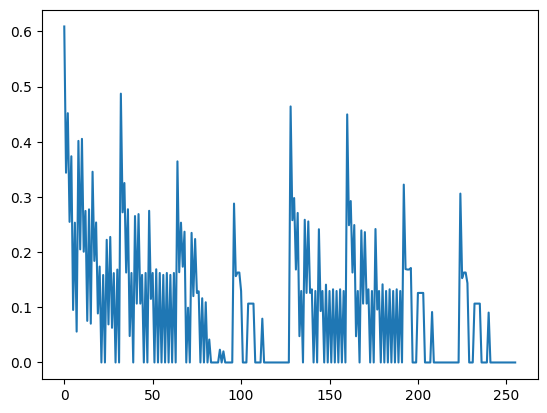

In [40]:
def all_binary_matrices(n, m):
    # Total number of binary matrices possible
    total_matrices = 2 ** (n * m)
    
    # Generate all binary matrices
    matrices = []
    for i in range(total_matrices):
        # Convert i to binary and pad with zeros
        binary_string = format(i, f'0{n*m}b')
        
        # Convert binary string to numpy array and reshape to (n, m)
        matrix = np.array([int(bit) for bit in binary_string]).reshape((n, m))
        matrices.append(matrix)
    
    return np.array(matrices)

x = all_binary_matrices(N_QUBITS,DEPTH)
Y = np.zeros(2**(N_QUBITS*DEPTH))
N = 100
for _ in range(N):
    random_layers = RandomLayers(N_QUBITS,DEPTH)
    y = [np.mean(circuit(theta,random_layers)) for theta in x]
    Y += y
Y = Y/N
plt.plot(Y)

In [67]:
min(Y)

tensor(-1.33226763e-17, requires_grad=True)

In [6]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
random_layers = RandomLayers(N_QUBITS,DEPTH)

circuit(theta,random_layers)
drawer = qml.draw(circuit)
print(drawer(theta,random_layers))

0: ─╭U(M0)────────────────╭U(M3)──|0⟩⟨0|─┤ ╭vnentropy                       ╭vnentropy
1: ─╰U(M0)──|0⟩⟨0|─╭U(M2)─│───────|0⟩⟨0|─┤ ╰vnentropy ╭vnentropy            │         
2: ─╭U(M1)──|0⟩⟨0|─╰U(M2)─│──────────────┤            ╰vnentropy ╭vnentropy │         
3: ─╰U(M1)────────────────╰U(M3)─────────┤                       ╰vnentropy ╰vnentropy

M0 = 
[[ 0.40160417+0.02303253j -0.02853437-0.48753798j -0.66818675+0.36484207j
  -0.09217666-0.10768614j]
 [ 0.35974832-0.07864062j  0.05291578-0.17963025j  0.18963165-0.29502029j
  -0.66351721+0.51582698j]
 [-0.54590599-0.5567398j   0.19548847+0.10132317j -0.36399485-0.03057567j
  -0.43781862-0.13576841j]
 [ 0.26601284-0.15441832j  0.75905579+0.31902599j  0.05540568+0.40115171j
   0.13800059+0.21074209j]]
M1 = 
[[-0.60590112-0.52663254j -0.00808666-0.02756116j -0.3549662 +0.47666623j
   0.03794593-0.00808666j]
 [-0.03794593+0.00808666j  0.55623762+0.20931174j  0.00808666+0.02756116j
  -0.33854664+0.72790396j]
 [-0.55623762+0.20931174j  0.037

In [133]:
def loss(theta, random_layers,alpha=10., beta=.1, gamma=.1):
    entropy = alpha*np.mean(circuit(theta,random_layers))
    budget = beta*np.mean(np.ndarray.flatten(theta))
    final_layer = gamma*np.mean(theta[:,-1])
    
    return entropy+budget+final_layer

In [134]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
loss(theta,random_layers)

tensor(1.64654836, requires_grad=True)

In [135]:
def grad(theta,random_layers):
    grads = np.zeros(np.shape(theta))

    for i in range(np.shape(theta)[0]):
        for j in range(np.shape(theta)[1]):
            h = np.zeros(np.shape(theta))
            h[i][j] = 1
            theta_prime = (theta+h)%2
            grads[i][j] = loss(theta_prime,random_layers) - loss(theta,random_layers)
    
    return grads
    

In [136]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
random_layers = RandomLayers(N_QUBITS,DEPTH)
grad(theta,random_layers)

tensor([[ 0.16080864, -2.65796819],
        [-0.0125    ,  0.0375    ],
        [ 0.0125    ,  3.13423986],
        [ 1.53024258, -2.65796819]], requires_grad=True)

In [137]:
np.unravel_index(np.argmin(grad(theta,random_layers)), shape=np.shape(theta))

(3, 1)

In [155]:
def main():
    n_training = 20
    random_layers = RandomLayers(N_QUBITS,DEPTH)
    theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
    for step in range(n_training):
        l = loss(theta,random_layers)
        entropy = np.mean(circuit(theta,random_layers))
        g = grad(theta,random_layers)
        dir = np.unravel_index(np.argmin(grad(theta,random_layers)), shape=np.shape(theta))
        h = np.zeros(np.shape(theta))
        h[dir[0]][dir[1]] = 1
        theta = (theta+h)%2


    return theta, l, entropy


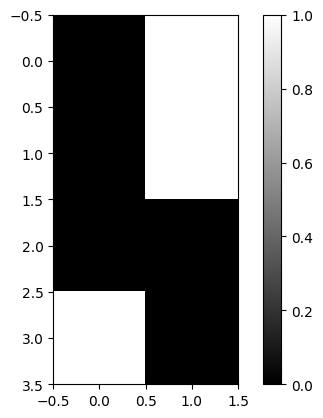


 Loss: 0.10000000000000117, 


In [156]:
theta, l, entropy = main()
plt.imshow(theta, cmap="gray")
plt.colorbar()
plt.show()
print("\n Loss: {}, \n Averaged von Neumann entropy: {}".format(l, entropy), end="\r")

In [150]:
epochs = 100
thetas = []
losses = []
entropies = []
for epoch in range(epochs):
    theta, l, entropy = main()
    thetas.append(theta)
    losses.append(l)
    entropies.append(entropy)

    print("\n Epoch: {}, Loss: {}".format(epoch+1, l), end="\r")


 Epoch: 1, Loss: 0.09999999999999959
 Epoch: 2, Loss: 0.08750000000001082
 Epoch: 3, Loss: 0.10000000000000238
 Epoch: 4, Loss: 0.1250000000000019
 Epoch: 5, Loss: 0.10000000000001247
 Epoch: 6, Loss: 0.11250000000001925
 Epoch: 7, Loss: 0.11250000000001051
 Epoch: 8, Loss: 0.10000000000000844
 Epoch: 9, Loss: 0.07500000000001025
 Epoch: 10, Loss: 0.11249999999999774
 Epoch: 11, Loss: 0.09909982171057903
 Epoch: 12, Loss: 0.08750000000000654
 Epoch: 13, Loss: 0.1000000000000075
 Epoch: 14, Loss: 0.08750000000000666
 Epoch: 15, Loss: 0.0750000000000114
 Epoch: 16, Loss: 0.1125000000000164
 Epoch: 17, Loss: 0.10000000000001616
 Epoch: 18, Loss: 0.08750000000001756
 Epoch: 19, Loss: 0.10000000000001791
 Epoch: 20, Loss: 0.08750000000000184
 Epoch: 21, Loss: 0.08750000000001057
 Epoch: 22, Loss: 0.06250000000002955
 Epoch: 23, Loss: 0.075000000000008
 Epoch: 24, Loss: 0.10000000000000067
 Epoch: 25, Loss: 0.06250000000003197
 Epoch: 26, Loss: 0.06250000000001035
 Epoch: 27, Loss: 0.062500

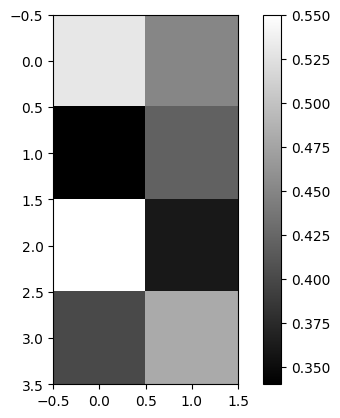

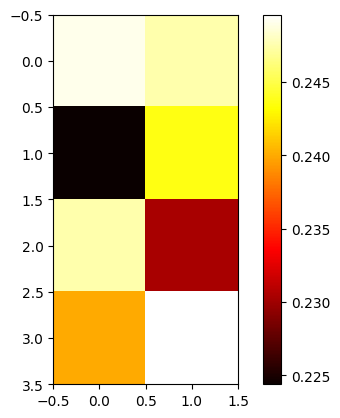

In [151]:
averaged_measurements = np.mean(thetas, axis=0)
variance_measurements = np.var(thetas, axis=0)

plt.figure()
plt.imshow(averaged_measurements, cmap="gray")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(variance_measurements, cmap="hot")
plt.colorbar()
plt.show()

In [152]:
optimal_theta = np.array([[1,1],
                          [0,0],
                          [0,1],
                          [1,0]])

random_layers = RandomLayers(N_QUBITS,DEPTH)
np.mean(circuit(optimal_theta,random_layers))

3.4358501484022423e-15

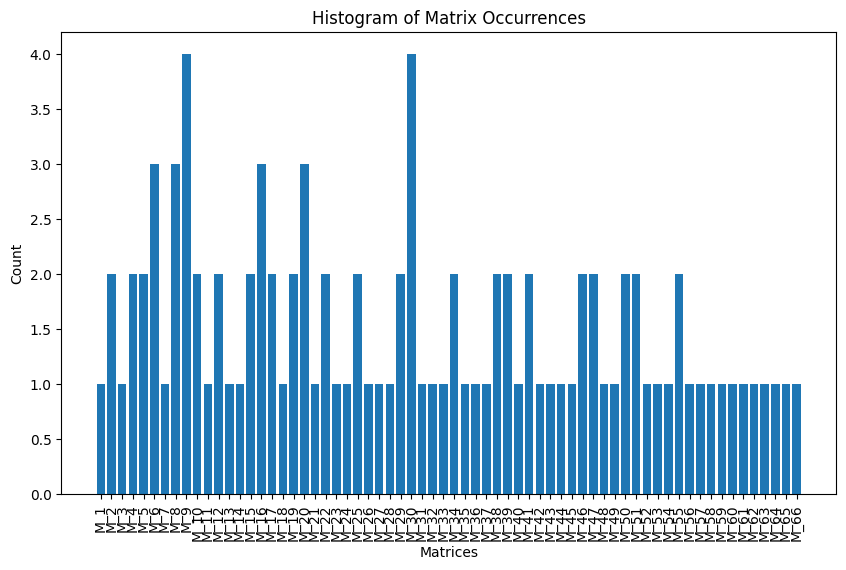

In [153]:
hashable_matrices = [tuple(map(tuple, matrix)) for matrix in thetas]

matrix_counts = Counter(hashable_matrices)

labels, counts = zip(*matrix_counts.items())

labels = [np.array(label) for label in labels]

plt.figure(figsize=(10,6))
plt.bar(range(len(counts)), counts, tick_label=["M_"+str(i+1) for i in range(len(labels))])
plt.xlabel('Matrices')
plt.ylabel('Count')
plt.title('Histogram of Matrix Occurrences')
plt.xticks(rotation=90)
plt.show()

In [98]:
hashable_matrices[32-1]

((tensor(1., requires_grad=True), tensor(1., requires_grad=True)),
 (tensor(0., requires_grad=True), tensor(0., requires_grad=True)),
 (tensor(0., requires_grad=True), tensor(1., requires_grad=True)),
 (tensor(1., requires_grad=True), tensor(0., requires_grad=True)))

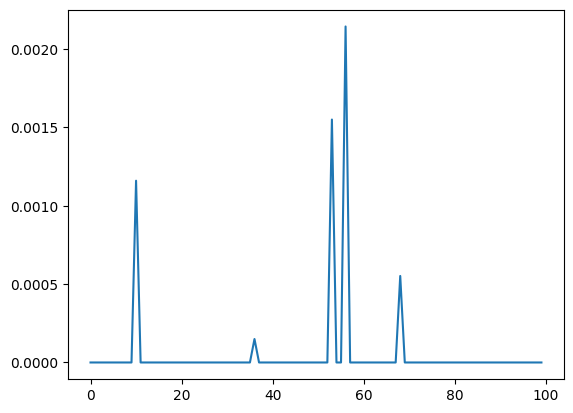

In [154]:
plt.plot(entropies)